In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def ReadVisium(path):
    from scipy.io import mmread
    Barcodes = pd.read_csv(f"{path}/filtered_feature_bc_matrix/barcodes.tsv.gz", header=None,
                           low_memory=False,
                           sep='\t')
    Barcodes = Barcodes.iloc[:, 0]
    Features = pd.read_csv(f"{path}/filtered_feature_bc_matrix/features.tsv.gz", header=None,
                           low_memory=False,
                           sep='\t')
    Features = Features.iloc[:, 1]
    Matrix = mmread(f"{path}/filtered_feature_bc_matrix/matrix.mtx.gz")
    from scipy import sparse
    Matrix = Matrix.transpose()
    Visium = pd.DataFrame.sparse.from_spmatrix(Matrix, columns=Features)
    Visium.set_index(Barcodes, inplace=True)
    Visium.index.names = ['Barcodes']
    return Visium

def ReadPositionsVisiumSD(path):
    Positions = pd.read_csv(f"{path}/spatial/tissue_positions.csv")
    Positions.set_index("barcode", inplace = True)
    Positions.index.names = ['Barcodes']
    return Positions

def DeconvolveCellTypes(Visium, df_clusters):

    cluster_sums = []

    for idx, gene_list in df_clusters.iloc[:, 0].items():
        # Filter for genes present in the expression data
        valid_genes = [gene for gene in gene_list if gene in Visium.index]
        # Sum expression values for these genes
        cluster_sum = Visium.loc[valid_genes].sum(axis=0)
        # Append result as a new row
        cluster_sums.append(cluster_sum)

    # Convert to DataFrame
    cluster_sum_df = pd.DataFrame(cluster_sums, index=df_clusters.index, columns=Visium.columns)
    return cluster_sum_df

def fit_negative_binomial(data):
    mean_val = np.mean(data)
    var_val = np.var(data)
    
    if var_val > mean_val:  # Ensuring the model applies
        r_est = mean_val ** 2 / (var_val - mean_val)  # Estimate r
        p_est = mean_val / var_val  # Estimate p
    else:
        r_est, p_est = np.nan, np.nan  # Handle edge cases where variance is too low
    
    return r_est, p_est

In [66]:
tissue_positions_data = ReadPositionsVisiumSD(".")

# Rotate Image
# Swap x and y
tissue_positions_data = tissue_positions_data.rename(columns={'pxl_row_in_fullres': 'pxl_col_in_fullres', 'pxl_col_in_fullres': 'pxl_row_in_fullres'})

# 1st mirror
# tissue_positions_data['pxl_col_in_fullres'] = -(tissue_positions_data['pxl_col_in_fullres']-tissue_positions_data['pxl_col_in_fullres'].max()) 
# 2nd mirror
tissue_positions_data['pxl_row_in_fullres'] = -(tissue_positions_data['pxl_row_in_fullres']-tissue_positions_data['pxl_row_in_fullres'].max()) 
tissue_positions_data.head()

,in_tissue,array_row,array_col,pxl_col_in_fullres,pxl_row_in_fullres
Barcodes,,,,,
ACGCCTGACACGCGCT-1,0,0,0,1408,12724
TACCGATCCAACACTT-1,0,1,1,1581,12624
ATTAAAGCGGACGAGC-1,0,0,2,1407,12525
GATAAGGGACGATTAG-1,0,1,3,1580,12425
GTGCAAATCACCAATA-1,0,0,4,1406,12326


In [4]:
Visium = ReadVisium(".")
Visium.rename_axis("Gene", axis=1,inplace=True)
Visium = Visium.T
Visium

Barcodes,AAACACCAATAACTGC-1,AAACAGGGTCTATATT-1,AAACATTTCCCGGATT-1,AAACCGGGTAGGTACC-1,AAACCGTTCGTCCAGG-1,AAACCTAAGCAGCCGG-1,AAACGAGACGGTTGAT-1,AAACGGGCGTACGGGT-1,AAACGGTTGCGAACTG-1,AAACTCGGTTCGCAAT-1,...,TTGTGGTAGGAGGGAT-1,TTGTGGTGGTACTAAG-1,TTGTGTATGCCACCAA-1,TTGTGTTTCCCGAAAG-1,TTGTTAGCAAATTCGA-1,TTGTTCAGTGTGCTAC-1,TTGTTGTGTGTCAAGA-1,TTGTTTCACATCCAGG-1,TTGTTTCATTAGTCTA-1,TTGTTTCCATACAACT-1
Gene,,,,,,,,,,,,,,,,,,,,,
SAMD11,0,0,1.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,0,0,0,0,0,0,0,0,0,1.0,...,0,0,2.0,0,1.0,0,1.0,0,1.0,0
KLHL17,0,0,0,0,0,0,0,0,0,1.0,...,0,0,0,1.0,0,0,0,0,0,0
PLEKHN1,0,0,0,0,0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PERM1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSPY1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
USP9Y,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DDX3Y,0,0,0,0,0,1.0,0,0,0,1.0,...,0,0,0,0,0,1.0,0,0,0,0


In [47]:
Metrics = pd.read_csv("./spatial/spatial_enrichment.csv")
Metrics.set_index("Feature Name", inplace = True)
Metrics.index.names = ['Gene']
Metrics.drop(Metrics[Metrics['Feature Counts in Spots Under Tissue'] < 250].index, inplace=True)
Metrics

,Feature ID,Feature Type,I,P value,Adjusted p value,Feature Counts in Spots Under Tissue,Median Normalized Average Counts,Barcodes Detected per Feature
Gene,,,,,,,,
CKM,ENSG00000104879,Gene Expression,0.790611,0.000000,0.000000,9590,8.127350,1612
DES,ENSG00000175084,Gene Expression,0.765935,0.000000,0.000000,13033,9.380368,1910
THBS4,ENSG00000113296,Gene Expression,0.753608,0.000000,0.000000,16606,10.421646,2218
TNNT3,ENSG00000130595,Gene Expression,0.742145,0.000000,0.000000,10451,8.056455,1839
TNNC2,ENSG00000101470,Gene Expression,0.737017,0.000000,0.000000,5366,4.804231,1382
...,...,...,...,...,...,...,...,...
CYB5R4,ENSG00000065615,Gene Expression,-0.012590,0.067196,0.151543,292,0.105230,266
EVI5,ENSG00000067208,Gene Expression,-0.013823,0.043998,0.104819,275,0.095985,252
FGFR1OP2,ENSG00000111790,Gene Expression,-0.014419,0.035888,0.087917,1378,0.531053,979


In [48]:
# Replace non 0 with 1 to get rid of the GEX levels
Visium_Corr = Visium.where(Visium == 0, 1)
# Visium_Corr = Visium
Visium_Corr = Visium_Corr[Visium_Corr.index.isin(Metrics.index)]
Visium_Corr = Visium_Corr.T
Visium_Corr.head()

Gene,NOC2L,HES4,ISG15,AGRN,SDF4,B3GALT6,UBE2J2,ACAP3,INTS11,CPTP,...,G6PD,IKBKG,DKC1,MPP1,CMC4,VBP1,TMLHE,VAMP7,DDX3Y,KDM5D
Barcodes,,,,,,,,,,,,,,,,,,,,,
AAACACCAATAACTGC-1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
AAACAGGGTCTATATT-1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTTCCCGGATT-1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
AAACCGGGTAGGTACC-1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
AAACCGTTCGTCCAGG-1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Perform gene corr analysis

corr_df = Visium_Corr
corr_df.rename_axis("Gene", inplace=True)
corr_df.rename_axis("Gene", axis=1,inplace=True)

correlation_matrix = corr_df.corr(method='pearson') # pearson / spearman 

correlation_matrix

Gene,NOC2L,HES4,ISG15,AGRN,SDF4,B3GALT6,UBE2J2,ACAP3,INTS11,CPTP,...,G6PD,IKBKG,DKC1,MPP1,CMC4,VBP1,TMLHE,VAMP7,DDX3Y,KDM5D
Gene,,,,,,,,,,,,,,,,,,,,,
NOC2L,1.000000,0.192720,0.152806,0.206503,0.173600,0.174072,0.163802,0.127038,0.159990,0.151193,...,0.196888,0.074262,0.150018,0.056751,0.087126,0.138999,0.060541,0.166830,0.065234,0.013285
HES4,0.192720,1.000000,0.257790,0.261547,0.209227,0.184901,0.188323,0.160334,0.204222,0.183893,...,0.219588,0.104595,0.176453,0.056366,0.106545,0.158587,0.089359,0.134206,0.079932,0.002955
ISG15,0.152806,0.257790,1.000000,0.308765,0.310408,0.187567,0.197898,0.146251,0.279787,0.152862,...,0.211441,0.115846,0.170950,0.074222,0.159473,0.151333,0.080898,0.138868,0.081652,0.064872
AGRN,0.206503,0.261547,0.308765,1.000000,0.307135,0.197898,0.214817,0.170519,0.252212,0.216112,...,0.260095,0.139636,0.185983,0.091728,0.169677,0.174461,0.110829,0.165243,0.101242,0.060004
SDF4,0.173600,0.209227,0.310408,0.307135,1.000000,0.166376,0.163368,0.137209,0.182384,0.158826,...,0.190523,0.130976,0.130103,0.060711,0.113097,0.145671,0.076458,0.132807,0.090399,0.061578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBP1,0.138999,0.158587,0.151333,0.174461,0.145671,0.138133,0.149561,0.089925,0.184537,0.133463,...,0.165607,0.102589,0.122565,0.016006,0.115119,1.000000,0.071775,0.117622,0.029572,-0.011381
TMLHE,0.060541,0.089359,0.080898,0.110829,0.076458,0.088921,0.061852,0.041572,0.053301,0.060153,...,0.144492,0.087513,0.071525,0.027092,0.064125,0.071775,1.000000,0.072747,0.027738,0.002054
VAMP7,0.166830,0.134206,0.138868,0.165243,0.132807,0.122530,0.098011,0.110810,0.119539,0.105561,...,0.168144,0.105655,0.137950,0.027751,0.078981,0.117622,0.072747,1.000000,0.045501,-0.004597


In [50]:
# # Perform gene corr analysis - this step is very slow

# corr_df = Visium_Corr
# corr_df.rename_axis("Gene", inplace=True)
# corr_df.rename_axis("Gene", axis=1,inplace=True)

# import dask.dataframe as dd

# # Convert Pandas DataFrame to Dask
# dask_df = dd.from_pandas(corr_df, npartitions=10)  # Adjust based on available CPU cores

# # Compute correlation
# correlation_matrix = dask_df.corr(method='pearson').compute()

# correlation_matrix

In [51]:
# Choose a threshold (something around 1.5)
threshold = 1.5

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

distance_matrix = 1 - correlation_matrix.abs()

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# Create a dictionary mapping clusters to feature lists
cluster_dict = {}
variables = correlation_matrix.columns

for var, cluster in zip(variables, clusters):
    cluster_dict.setdefault(cluster, []).append(var)

# Remove clusters if needed
filtered_clusters = {k: v for k, v in cluster_dict.items() if len(v) >= 0}

# Convert to DataFrame
df_clusters = pd.DataFrame({'Cluster': list(filtered_clusters.keys()), 'Genes': list(filtered_clusters.values())})
df_clusters.set_index('Cluster', inplace=True)

df_clusters.to_excel('Distance Clusters.xlsx')
df_clusters

,Genes
Cluster,
25,"[NOC2L, B3GALT6, AURKAIP1, KLHL21, CAMTA1, VAM..."
27,"[HES4, CPTP, UBR4, CAMK2N1, EIF4G3, KDM1A, SRS..."
20,"[ISG15, SDF4, GNB1, PARK7, CAPZB, HSPG2, TMEM5..."
17,"[AGRN, CTNNBIP1, MFAP2, CLIC4, SH3BGRL3, SERIN..."
23,"[UBE2J2, ACAP3, VWA1, PRXL2B, WRAP73, TP73, LR..."
18,"[INTS11, CCNL2, SSU72, RER1, CLSTN1, LZIC, PGD..."
30,"[DVL1, AJAP1, CASZ1, EPHA2, WNT4, MACO1, CRYBG..."
8,"[MXRA8, MEGF6, ID3, GPX7, OLFML3, ATP8B2, OLFM..."
3,"[MIB2, CDK11B, FAAP20, SKI, C1orf174, KCNAB2, ..."


In [52]:
Visium = Visium[Visium.index.isin(Metrics.index)]
Visium = Visium[~Visium.index.duplicated(keep="first")]
Visium

Barcodes,AAACACCAATAACTGC-1,AAACAGGGTCTATATT-1,AAACATTTCCCGGATT-1,AAACCGGGTAGGTACC-1,AAACCGTTCGTCCAGG-1,AAACCTAAGCAGCCGG-1,AAACGAGACGGTTGAT-1,AAACGGGCGTACGGGT-1,AAACGGTTGCGAACTG-1,AAACTCGGTTCGCAAT-1,...,TTGTGGTAGGAGGGAT-1,TTGTGGTGGTACTAAG-1,TTGTGTATGCCACCAA-1,TTGTGTTTCCCGAAAG-1,TTGTTAGCAAATTCGA-1,TTGTTCAGTGTGCTAC-1,TTGTTGTGTGTCAAGA-1,TTGTTTCACATCCAGG-1,TTGTTTCATTAGTCTA-1,TTGTTTCCATACAACT-1
Gene,,,,,,,,,,,,,,,,,,,,,
NOC2L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
HES4,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
ISG15,0.0,0.0,4.0,1.0,1.0,24.0,5.0,4.0,0.0,8.0,...,1.0,2.0,15.0,10.0,10.0,20.0,19.0,1.0,0.0,1.0
AGRN,1.0,0.0,0.0,0.0,1.0,4.0,0.0,3.0,0.0,1.0,...,0.0,0.0,8.0,7.0,10.0,3.0,4.0,0.0,0.0,1.0
SDF4,0.0,1.0,2.0,3.0,2.0,4.0,1.0,0.0,0.0,2.0,...,2.0,0.0,5.0,7.0,7.0,8.0,3.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBP1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TMLHE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
VAMP7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [53]:
deconvolution = DeconvolveCellTypes(Visium, df_clusters)
deconvolution

Barcodes,AAACACCAATAACTGC-1,AAACAGGGTCTATATT-1,AAACATTTCCCGGATT-1,AAACCGGGTAGGTACC-1,AAACCGTTCGTCCAGG-1,AAACCTAAGCAGCCGG-1,AAACGAGACGGTTGAT-1,AAACGGGCGTACGGGT-1,AAACGGTTGCGAACTG-1,AAACTCGGTTCGCAAT-1,...,TTGTGGTAGGAGGGAT-1,TTGTGGTGGTACTAAG-1,TTGTGTATGCCACCAA-1,TTGTGTTTCCCGAAAG-1,TTGTTAGCAAATTCGA-1,TTGTTCAGTGTGCTAC-1,TTGTTGTGTGTCAAGA-1,TTGTTTCACATCCAGG-1,TTGTTTCATTAGTCTA-1,TTGTTTCCATACAACT-1
Cluster,,,,,,,,,,,,,,,,,,,,,
25,125.0,108.0,420.0,125.0,243.0,798.0,556.0,302.0,122.0,521.0,...,149.0,137.0,1273.0,754.0,1131.0,1107.0,999.0,211.0,124.0,239.0
27,52.0,74.0,217.0,58.0,125.0,290.0,273.0,110.0,63.0,173.0,...,89.0,39.0,392.0,264.0,350.0,403.0,333.0,93.0,50.0,91.0
20,97.0,119.0,558.0,147.0,247.0,926.0,642.0,357.0,109.0,524.0,...,138.0,149.0,1300.0,851.0,1321.0,1336.0,1894.0,218.0,98.0,204.0
17,19.0,31.0,106.0,26.0,45.0,302.0,144.0,101.0,18.0,139.0,...,21.0,48.0,499.0,252.0,457.0,423.0,778.0,29.0,11.0,34.0
23,59.0,57.0,214.0,57.0,129.0,376.0,243.0,193.0,59.0,264.0,...,102.0,51.0,606.0,351.0,479.0,545.0,401.0,96.0,61.0,128.0
18,120.0,129.0,632.0,193.0,304.0,993.0,746.0,367.0,146.0,657.0,...,202.0,152.0,1409.0,897.0,1296.0,1335.0,1231.0,303.0,127.0,242.0
30,6.0,6.0,21.0,5.0,16.0,52.0,34.0,23.0,4.0,26.0,...,6.0,5.0,70.0,45.0,64.0,57.0,168.0,8.0,6.0,8.0
8,26.0,28.0,105.0,49.0,47.0,66.0,135.0,22.0,21.0,49.0,...,27.0,9.0,90.0,91.0,99.0,123.0,79.0,61.0,18.0,52.0
3,90.0,103.0,358.0,91.0,232.0,478.0,406.0,182.0,109.0,287.0,...,179.0,70.0,610.0,399.0,582.0,609.0,490.0,200.0,109.0,197.0


In [54]:
df = deconvolution.T

percentile = 0.9 # 0.8 - 0.95 is the recommended range

from scipy.stats import nbinom

# Extract numeric data (excluding Gene column if present)
df_numeric = df.iloc[:, 0:] 

# Fit NB parameters for each feature
nb_params = {col: fit_negative_binomial(df_numeric[col]) for col in df_numeric.columns}
nb_params_df = pd.DataFrame(nb_params, index=["r", "p"]).T

# Compute 80th percentile threshold
thresholds = {col: nbinom.ppf(percentile, nb_params_df.loc[col, "r"], nb_params_df.loc[col, "p"]) 
                 for col in df_numeric.columns}

# Convert to DataFrame
thresholds_df = pd.DataFrame.from_dict(thresholds, orient="index", columns=["UMI Th"])

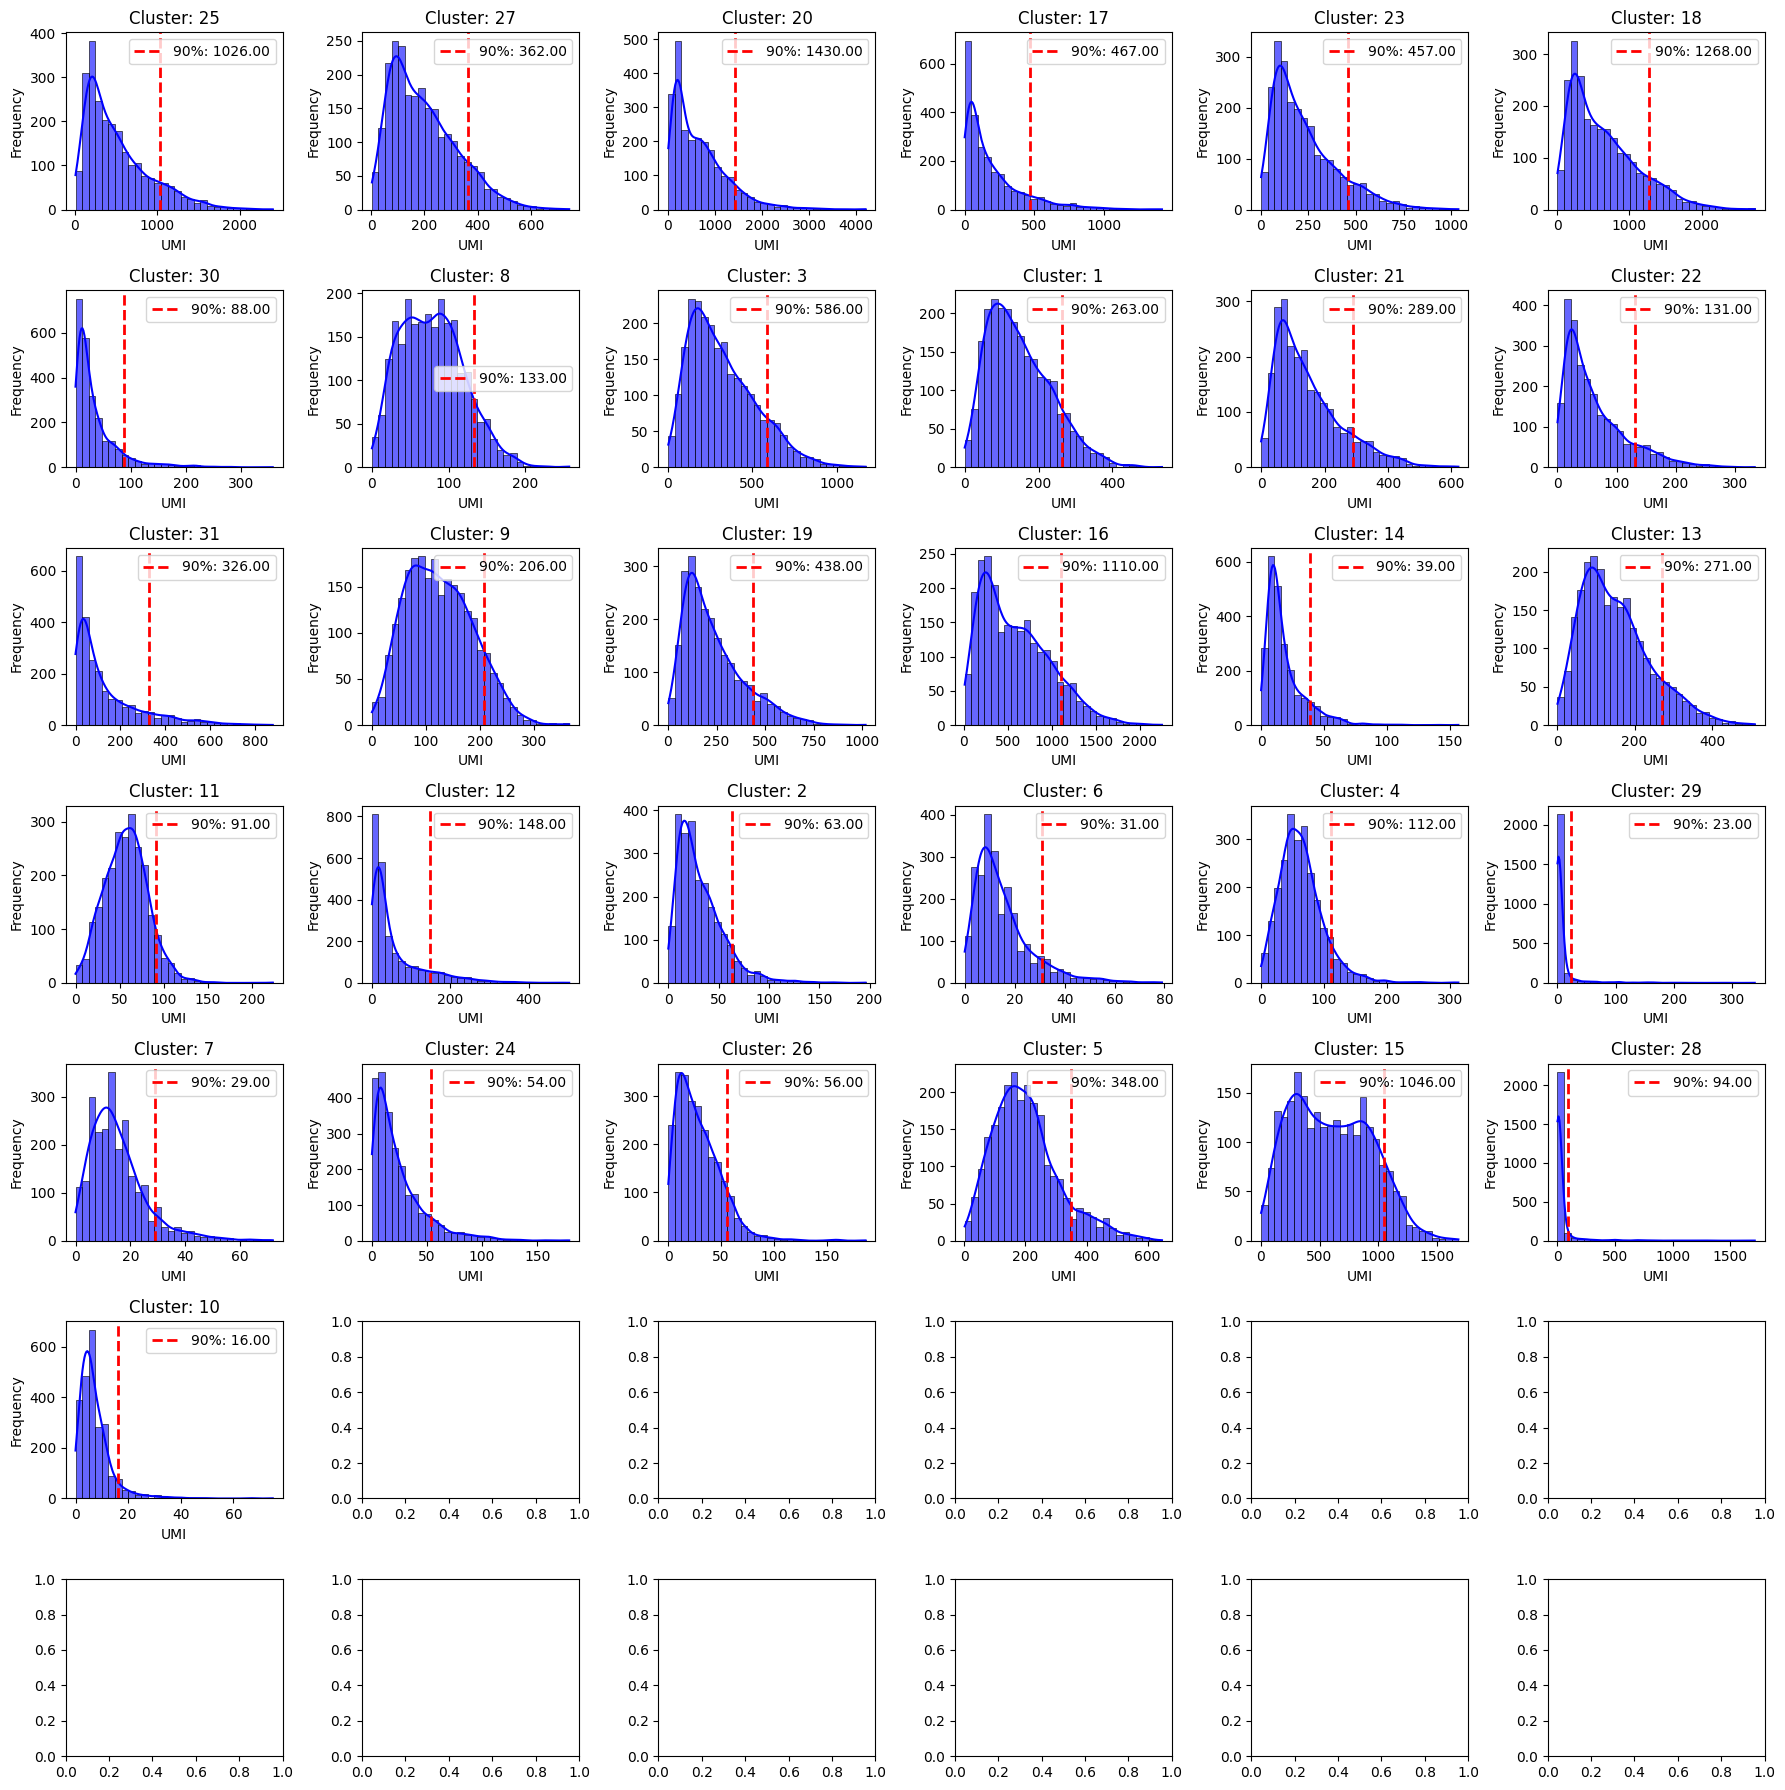

In [55]:
# Plot histograms with percentile threshold lines
fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(df_numeric.columns):
    ax = axes[i]
    sns.histplot(df_numeric[col], bins=30, kde=True, color="blue", edgecolor="black", alpha=0.6, ax=ax)
    ax.axvline(thresholds[col], color="red", linestyle="dashed", linewidth=2, label=f"90%: {thresholds[col]:.2f}")
    ax.set_title(f"Cluster: {col}")
    ax.set_xlabel("UMI")
    ax.set_ylabel("Frequency")
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [56]:
# thresholds_df.T

In [57]:
# # UMI Th should be placed directly afther the main distrubution or inbetween the two in case of a bi-modal distribution

# updated_th = [25.0,57.0,422.0,25.0,11.0,25.0,17.0,9.0,34.0,50.0,75.0,50.0,34.0,120.0,440.0,548.0,210.0,250.0]

# keys = list(thresholds.keys())

# for k, v in zip(keys, updated_th):
#     thresholds[k] = v

# thresholds_df = pd.DataFrame.from_dict(thresholds, orient="index", columns=["UMI Th"])

# # Plot histograms with 99th percentile threshold lines
# fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(18, 10))
# axes = axes.flatten()

# for i, col in enumerate(df_numeric.columns):
#     ax = axes[i]
#     sns.histplot(df_numeric[col], bins=30, kde=True, color="blue", edgecolor="black", alpha=0.6, ax=ax)
#     ax.axvline(thresholds[col], color="red", linestyle="dashed", linewidth=2, label=f"Th: {thresholds[col]:.2f}")
#     ax.set_title(f"Cluster: {col}")
#     ax.set_xlabel("UMI")
#     ax.set_ylabel("Frequency")
#     ax.legend()

# # Adjust layout
# plt.tight_layout()
# plt.show()

In [58]:
# Calculate putative cell count per spot 
# by replacing the values less than the percentile threshold with 0, counting medians, and dividing by them
thresholds_broadcasted = thresholds_df.reindex(deconvolution.index).values 

deconvolution_filtered = deconvolution.where(deconvolution >= thresholds_broadcasted, 0)

deconvolution_nonzero = deconvolution_filtered.replace(0, np.nan)

cluster_medians = deconvolution_nonzero.median(axis=1, numeric_only=True)

cell_count = np.ceil(deconvolution_nonzero.div(cluster_medians, axis=0))

cell_count = cell_count.fillna(0).astype(int)

cell_count.T.sum()

Cluster
25    435
27    419
20    364
17    414
23    421
18    433
30    326
8     364
3     420
1     400
21    417
22    439
31    445
9     400
19    411
16    414
14    387
13    406
11    303
12    443
2     339
6     363
4     316
29    301
7     347
24    381
26    370
5     368
15    369
28    372
10    273
dtype: int64

In [64]:
cells_per_spot = 5 # Set putative meadian cell per spot count
spots = deconvolution.shape[1]

print(f'                       The predicted total cell number is {spots * cells_per_spot}')
print(f'The total cell number observed after the deconvolution is {cell_count.T.sum().sum()}')
print(f'                                The ratio is {(spots * cells_per_spot)/(cell_count.T.sum().sum())}')

                       The predicted total cell number is 12115
The total cell number observed after the deconvolution is 11860.0
                                The ratio is 1.0215008431703203


In [60]:
# Call Putative cell clusters per spot

# Convert Visium and cell_count to dense format
Visium = Visium.astype(float)
cell_count = cell_count.astype(float)

# Create a new DataFrame for subcells
filtered_columns = [
    f"{spot}_{cluster}" for spot in Visium.columns for cluster in df_clusters.index
    if cell_count.at[cluster, spot] > 0  # Only keep clusters with nonzero putative cell counts
]

# Initialize putative_cell_df with only the required columns
putative_cell_df = pd.DataFrame(0, index=Visium.index, columns=filtered_columns, dtype=float)

# Populate putative_cell_df with gene expression values
for spot in Visium.columns:
    for cluster, genes in df_clusters["Genes"].items():
        if cell_count.at[cluster, spot] > 0:  # Check if putative cell count is above 0
            subspot_name = f"{spot}_{cluster}"  
            putative_cell_df[subspot_name] = Visium[spot]  # Copy UMI cell values
            putative_cell_df.loc[~putative_cell_df.index.isin(genes), subspot_name] = 0  # Set non-cluster genes to 0

putative_cell_per_spot = putative_cell_df.astype(int)

putative_cell_per_spot

,AAACATTTCCCGGATT-1_14,AAACCTAAGCAGCCGG-1_26,AAACGAGACGGTTGAT-1_8,AAACGAGACGGTTGAT-1_14,AAACGAGACGGTTGAT-1_13,AAACTCGGTTCGCAAT-1_26,AAACTGCTGGCTCCAA-1_10,AAACTTGCAAACGTAT-1_6,AAAGGCCCTATAATAC-1_12,AAAGGCTCTCGCGCCG-1_14,...,TTGTTGTGTGTCAAGA-1_30,TTGTTGTGTGTCAAGA-1_22,TTGTTGTGTGTCAAGA-1_31,TTGTTGTGTGTCAAGA-1_19,TTGTTGTGTGTCAAGA-1_2,TTGTTGTGTGTCAAGA-1_29,TTGTTGTGTGTCAAGA-1_28,TTGTTTCACATCCAGG-1_10,TTGTTTCATTAGTCTA-1_12,TTGTTTCCATACAACT-1_14
Gene,,,,,,,,,,,,,,,,,,,,,
NOC2L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HES4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ISG15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AGRN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDF4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBP1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TMLHE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
VAMP7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# Call Putative cells per spot

cell_count.index = cell_count.index.astype(str)
cell_count.columns = cell_count.columns.astype(str)

# Initialize a new DataFrame for putative_cells
putative_cell_data = {}

# Iterate through each subcell in putative_cell_per_spot
for subcell in putative_cell_per_spot.columns:
    cell, cluster = map(str, subcell.split("_"))  # Ensure names are strings
    
    # Check if cluster and cell exist in cell_count before accessing
    if cluster in cell_count.index and cell in cell_count.columns:
        putative_count = cell_count.at[cluster, cell]
    else:
        print(f"Warning: Skipping {subcell} - No match found in cell_count")
        continue  # Skip this subcell if the match isn't found

    if putative_count > 0:  # Only process if there are putative_cells
        putative_count = int(np.ceil(putative_count))  # Ensure it's an integer
        split_values = np.ceil(putative_cell_per_spot[subcell] / putative_count).astype(int)
    
        # Create new columns for each putative_cell
        for i in range(1, putative_count + 1):  # Now `putative_count` is an integer
            putative_cell_name = f"{subcell}_{i}"
            putative_cell_data[putative_cell_name] = split_values

# Convert to DataFrame
putative_cell_df = pd.DataFrame(putative_cell_data)

putative_cell_df = putative_cell_df.loc[:, putative_cell_df.sum(axis=0) != 0]

putative_cell_df = putative_cell_df.astype(str)

putative_cell_df = putative_cell_df[~putative_cell_df.index.duplicated(keep="first")]

putative_cell_df

,AAACATTTCCCGGATT-1_14_1,AAACCTAAGCAGCCGG-1_26_1,AAACCTAAGCAGCCGG-1_26_2,AAACGAGACGGTTGAT-1_8_1,AAACGAGACGGTTGAT-1_14_1,AAACGAGACGGTTGAT-1_14_2,AAACGAGACGGTTGAT-1_14_3,AAACGAGACGGTTGAT-1_13_1,AAACTCGGTTCGCAAT-1_26_1,AAACTCGGTTCGCAAT-1_26_2,...,TTGTTGTGTGTCAAGA-1_19_1,TTGTTGTGTGTCAAGA-1_2_1,TTGTTGTGTGTCAAGA-1_2_2,TTGTTGTGTGTCAAGA-1_29_1,TTGTTGTGTGTCAAGA-1_29_2,TTGTTGTGTGTCAAGA-1_28_1,TTGTTTCACATCCAGG-1_10_1,TTGTTTCATTAGTCTA-1_12_1,TTGTTTCATTAGTCTA-1_12_2,TTGTTTCCATACAACT-1_14_1
Gene,,,,,,,,,,,,,,,,,,,,,
NOC2L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HES4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ISG15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AGRN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SDF4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VBP1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TMLHE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
VAMP7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
import json
import math

# Load the JSON file
with open("./spatial/scalefactors_json.json", "r") as file:
    scalefactors = json.load(file)

# Extract and round up the spot radius
SPOT_RADIUS = math.ceil(scalefactors["spot_diameter_fullres"])
SPOT_RADIUS

130

In [62]:
# Randomly allocate Putative cells within their spot

# Spot radius and min distance
MIN_DISTANCE = SPOT_RADIUS/15*6 # Minimum pixel separation between putative_cells

# Initialize spatial coordinates dictionary
putative_cell_spatial = {}

# Iterate over putative_cells and assign random spatial positions
for putative_cell in putative_cell_df.columns:
    # Extract the correct `cell_cluster` name
    cell_cluster = putative_cell.split("_", 1)[0]  # Keep only barcode (remove extra numbers)

    if cell_cluster in tissue_positions_data.index:
        center_x = tissue_positions_data.at[cell_cluster, "pxl_row_in_fullres"]
        center_y = tissue_positions_data.at[cell_cluster, "pxl_col_in_fullres"]
    else:
        print(f"Warning: {cell_cluster} not found in tissue_positions_data")
        continue  # Skip if no spatial data

    # Generate unique positions within spot radius
    putative_cell_positions = []
    attempts = 0
    
    while len(putative_cell_positions) < 1:  # Only need one valid position per putative_cell
        # Randomly place within the spot's circular area
        rand_radius = np.random.uniform(0, SPOT_RADIUS)
        rand_angle = np.random.uniform(0, 2 * np.pi)
        new_x = center_x + rand_radius * np.cos(rand_angle)
        new_y = center_y + rand_radius * np.sin(rand_angle)
        
        # Ensure at least MIN_DISTANCE separation from other putative_cells
        if all(np.sqrt((new_x - x)**2 + (new_y - y)**2) >= MIN_DISTANCE for x, y in putative_cell_positions):
            putative_cell_positions.append((new_x, new_y))
            putative_cell_spatial[putative_cell] = (new_x, new_y)
        else:
            attempts += 1
            if attempts > 100:  # Prevent infinite loops
                print(f"Warning: Could not place {putative_cell} with required spacing")
                break

# Convert to mimic the Vizgen format
putative_cell_spatial_df = pd.DataFrame.from_dict(putative_cell_spatial, orient="index", columns=["center_x", "center_y"])
putative_cell_spatial_df['z'] = 0
putative_cell_spatial_df['fov'] = 0

# Export data in Vizgen format
putative_cell_df.astype(int).T.to_csv('cell_by_gene.csv') 
putative_cell_spatial_df.to_csv('cell_metadata.csv')

putative_cell_spatial_df

,center_x,center_y,z,fov
AAACATTTCCCGGATT-1_14_1,11116.546099,2997.346713,0,0
AAACCTAAGCAGCCGG-1_26_1,9904.174023,2347.988694,0,0
AAACCTAAGCAGCCGG-1_26_2,9847.606896,2328.246216,0,0
AAACGAGACGGTTGAT-1_8_1,9409.838983,7469.160845,0,0
AAACGAGACGGTTGAT-1_14_1,9331.126521,7479.251772,0,0
...,...,...,...,...
TTGTTGTGTGTCAAGA-1_28_1,9243.010234,8259.266984,0,0
TTGTTTCACATCCAGG-1_10_1,5699.840250,3708.060489,0,0
TTGTTTCATTAGTCTA-1_12_1,4602.769876,3175.265888,0,0
TTGTTTCATTAGTCTA-1_12_2,4568.462920,3354.604424,0,0


In [63]:
# Export Cluster numbers
cluster_df = putative_cell_spatial_df.index.str.extract(r'-1_(\d+)_')
cluster_df = cluster_df.rename(columns={0: 'Cluster'})
cluster_df.index = putative_cell_spatial_df.index
cluster_df.to_csv('cluster_info.csv')
cluster_df.head()

,Cluster
AAACATTTCCCGGATT-1_14_1,14
AAACCTAAGCAGCCGG-1_26_1,26
AAACCTAAGCAGCCGG-1_26_2,26
AAACGAGACGGTTGAT-1_8_1,8
AAACGAGACGGTTGAT-1_14_1,14
